## TOC:
* [Distributed Classification via Logistic Regression](#pookie1)
* [Task 1.1 – Distributed Optimization](#pookie2)
* * [Parameters](#pookie2.1)
* [Task 1.2 - Centralized Classification](#pookie3)
* * [Select Conic Shape](#pookie3.1)
* * [Parameters](#pookie3.2)
* * [Paramenters - Gradient Method](#pookie3.3)
* [Task 1.3 - Distributed Classification](#pookie4)
* * [Parameters](#pookie4.1)

# <a name="pookie"></a>Distributed Classification via Logistic Regression
##### Suppose to have N agents that want to cooperatively determine a nonlinear classifier for a set of points in a given feature space.

## <a name="pookie2"></a>Task 1.1 – Distributed Optimization 

As a preliminary task, implement the Gradient Tracking algorithm to solve a consensus
optimization problem in the form 
                                $$ min_{z}\sum^{N}_{i=1} l_i(z) $$
with $z \in \mathbb{R}^{d}$ while $\ell_{i}: \mathbb{R}^{d} \mapsto \mathbb{R}$ is a quadratic function, for all $i \in\{1, \ldots, N\}$. You can extend the code provided during lectures.

Run a set of simulations to test the effectiveness of the implementation. Moreover, provide a set of solutions that includes different weighted graph patterns (e.g., cycle, path, star) whose weights are determined by the Metropolis-Hastings method. Finally, for each simulation, plot the evolution of the cost function and of the norm of the gradient of the cost function across the iterations.

In [1]:
### Libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sympy import symbols, Eq, solve
from scipy.optimize import minimize
import sympy as sp
import sys
import math
from sklearn.model_selection import train_test_split
import matplotlib
import random as rand
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/home/andrea/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


##### Quadratic function and it's derivative

In [2]:
def quadratic(z, a, b):
    return 0.5*a*z*z+b*z

def grad_quadratic(z, a, b):
    return a*z+b

#### Metropolis hastings methods to define graph weights

In [3]:
def metropolis_hastings(N, Adj):
    
    I = np.eye(N)
    A = np.zeros(shape=(N,N))
    for i in range(N):
        neighbors = np.nonzero(Adj[i])[0]
        degree_i = len(neighbors)

        for j in neighbors:
            degree_j = len(np.nonzero(Adj[j])[0])
            A[i,j] = 1/(1+max([degree_i, degree_j]))

    A += I-np.diag(np.sum(A, axis=0))
    return A

#### Generate strongly connected graph

In [4]:
def generate_graph(N, seed):
    
    I_N = np.eye(N)
    np.random.seed(seed)
    while 1:
        Adj = np.random.binomial(n=1, p=0.3, size=(N, N))
        Adj = np.logical_or(Adj, Adj.T)
        Adj = np.logical_and(Adj, np.logical_not(I_N)).astype(int)

        test = np.linalg.matrix_power(I_N + Adj, N)
        if np.all(test > 0):
            break
        # else:
        # continue
    return Adj

#### Gradient Tracking
$$
\begin{aligned}
z_{i}^{k+1} & =\sum_{j \in N_{i}} a_{i j} z_{j}^{k}-\alpha s_{i}^{k} & z_{i}^{0} \in \mathbb{R} \\
s_{i}^{k+1} & =\sum_{j \in N_{i}} a_{i j} s_{j}^{k}+\nabla \ell_{i}\left(z_{i}^{k+1}\right)-\nabla \ell_{i}\left(z_{i}^{k}\right) & s_{i}^{0}=\nabla \ell_{i}\left(z_{i}^{0}\right)
\end{aligned}
$$

In [5]:
def gradient_tracking(iterations, N, A,Adj, alpha, a,b):
    
    Z = np.zeros((iterations, N))
    S = np.zeros((iterations, N))
    for i in range(N):
        S[0,i] = grad_quadratic(Z[0,i], a[i], b[i])

    cost = np.zeros((iterations))

    for k in range(iterations-1):
        for i in range(N):
            neighbors = np.nonzero(Adj[i])[0]

            Z[k+1,i] += Z[k,i] * A[i,i]
            S[k+1,i] += S[k,i] * A[i,i]

            for j in neighbors:
                Z[k+1,i] += Z[k,j] * A[i,j]
                S[k+1,i] += S[k,j] * A[i,j]

            Z[k+1, i] -= alpha * S[k,i]

            nabla_new = grad_quadratic(Z[k+1,i], a[i], b[i])
            nabla_old = grad_quadratic(Z[k,i], a[i], b[i])
            S[k+1,i] +=  nabla_new - nabla_old

            cost[k] += quadratic(Z[k,i], a[i], b[i])

    return Z,S, cost

In [6]:
def plot_results(iterations, Z,S, cost):
    
    fig, ax = plt.subplots()
    ax.plot(np.arange(iterations), Z)
    ax.title.set_text('Agents\' States')
    ax.grid()

    fig, ax = plt.subplots()
    ax.semilogy(np.arange(iterations), S)
    ax.title.set_text('Agents\' Gradient')
    ax.grid()
    
    fig, ax = plt.subplots()
    average_gradient = np.mean(S, axis=1)
    ax.semilogy(np.arange(iterations), average_gradient)
    ax.title.set_text('Average Gradient')
    ax.grid()


    Z_opt = -np.sum(b) / np.sum(a)
    opt_cost = 0.5 * np.sum(a) * Z_opt**2 + np.sum(b) * Z_opt

    fig, ax = plt.subplots()
    ax.title.set_text('Cost')
    ax.semilogy(np.arange(iterations-1), np.abs(cost[:-1] - opt_cost))
    ax.grid()

    plt.show()

#### <a name="pookie2.1"></a> Parameters

In [7]:
seed = 0 #random seed
iterations = 100 #number of iterations
N = 10 #number of agents
alpha = 1e-3 #step-size

a = np.random.uniform(size=N)
b = np.random.uniform(size=N)

Adj = generate_graph(N,seed)
A = metropolis_hastings(N, Adj)

In [8]:
#generate graph
G = nx.path_graph(N)
Adj = nx.adjacency_matrix(G).toarray()
A = metropolis_hastings(N, Adj)

#### Simulations

In [9]:
#launch gradient tracking algorithm
Z,S, cost = gradient_tracking(iterations, N, A, Adj, alpha, a, b)

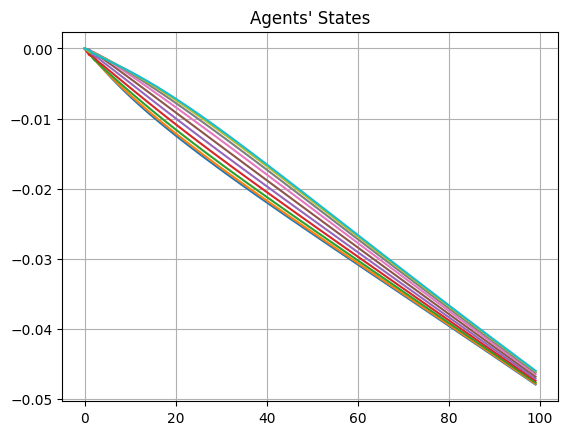

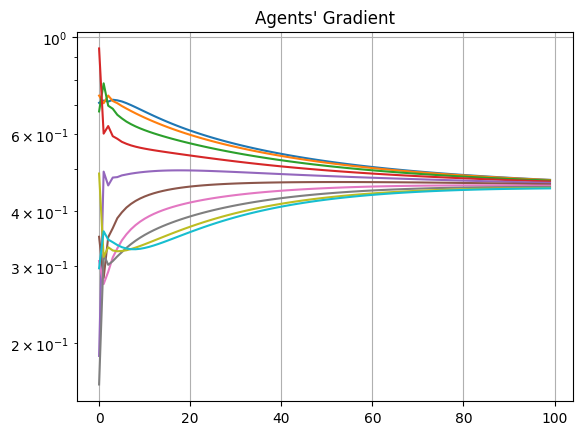

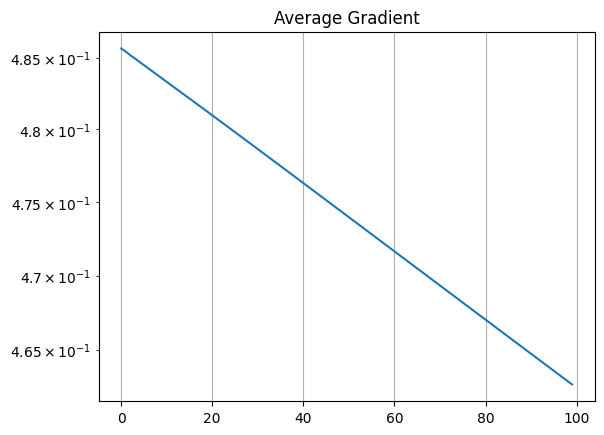

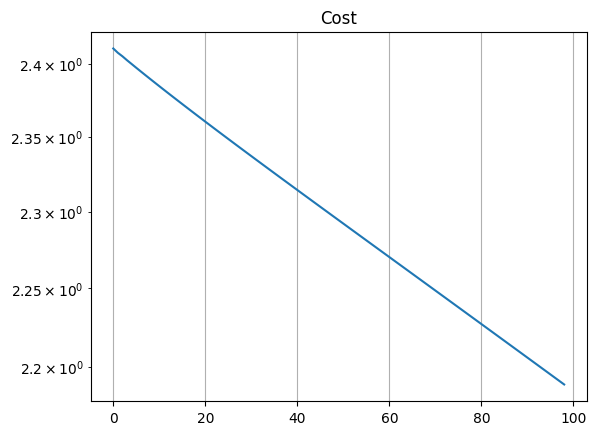

In [10]:
plot_results(iterations, Z,S, cost)

## <a name="pookie3"></a>Task 1.2 - Centralized Classification

1. Generate a dataset of $\mathcal{M} \in \mathbb{N}$ points $\mathcal{D}^{m} \in \mathbb{R}^{d}, m=1, \ldots, \mathcal{M}$.

2. Label the points with a binary label $p^{m} \in\{-1,1\}$ for all $m=1, \ldots, \mathcal{M}$. The separating function is given in the form

$$
\left\{x \in \mathbb{R}^{d} \mid w^{\top} \varphi(x)+b=0\right\},
$$

with $\varphi: \mathbb{R}^{d} \rightarrow \mathbb{R}^{q}$ a nonlinear function and $w \in \mathbb{R}^{q}, b \in \mathbb{R}$ parameters. Hence,

$$
\begin{array}{ll}
w^{\top} \varphi\left(\mathcal{D}^{m}\right)+b \geq 0, & \text { if } p^{m}=1, \text { and } \\
w^{\top} \varphi\left(\mathcal{D}^{m}\right)+b<0, & \text { if } p^{m}=-1 .
\end{array}
$$


Hint. In a two-dimensional example, assuming $\mathcal{D}=\left([\mathcal{D}]_{1},[\mathcal{D}]_{2}\right) \in \mathbb{R}^{2}$, the separating function can be an ellipse. To this end, define

$$
\varphi(\mathcal{D}):=\left[\begin{array}{c}
{[\mathcal{D}]_{1}} \\
{[\mathcal{D}]_{2}} \\
\left([\mathcal{D}]_{1}\right)^{2} \\
\left([\mathcal{D}]_{2}\right)^{2}
\end{array}\right]
$$

3. Implement a (centralized) Gradient Method to minimize a Logistic Regression Function in order to classify the points. The resulting optimization problem is


$$
\min _{w, b} \sum_{m=1}^{\mathcal{M}} \log \left(1+\exp \left(-p^{m}\left(w^{\top} \varphi\left(\mathcal{D}^{m}\right)+b\right)\right)\right)
$$ 
where $(w, b) \in \mathbb{R}^{q} \times \mathbb{R}$ is the optimization variable.


4. Run a set of simulations to test the effectiveness of the implementation. Moreover, provide a set of solutions that includes, e.g., different dataset patterns. Finally, for each simulation, plot the evolution of the cost function and of the norm of the gradient of the cost function across the iterations.


#### Auxilliary functions

In [11]:
def compute_semiaxes(a, b, c, d, g, center):
    
    x, y = symbols('x y')
    x_c, y_c = center

    # Initialize intersection points
    x_ints = [0, 0]
    y_ints = [0, 0]

    # Solve for x when y = yc to find x-intersections
    eq_x = a*x + b*y_c + c*x**2 + d*y_c**2 + g
    x_ints = sp.solve(eq_x, x)

    # Solve for y when x = xc to find y-intersections
    eq_y = a*x_c + b*y + c*x_c**2 + d*y**2 + g #put a plus to avoid complex solutions
    y_ints = sp.solve(eq_y, y)

    #add the center
    x_ints.extend([x_c])
    y_ints.extend([y_c])

    #find the distances from the origin
    min_ox = min(x_ints)
    max_ox = max(x_ints)
    min_oy = min(y_ints)
    max_oy = max(y_ints)
    dist_o = [min_ox, max_ox, min_oy, max_oy]
    
    return dist_o, x_ints, y_ints

def compute_center(a, b, c, d, g):

    #define symbolic letters
    x, y = symbols('x y')

    #define the equation
    eq = a*x + b * y + c* (x**2) + d * (y**2) - g

    #solve system of equations to find center's coordinates
    sol = solve((eq.diff(x), eq.diff(y)), (x, y))

    if sol: #there is a solution (non-empty list)
        center = [0,0]
        center[0] = float(sol[x])
        center[1] = float(sol[y])

    else: #there is no center (empty list)

        print("\nThe conic function has no predefined center.")
        center = None
    
    return center

In [12]:
def generate_two_dimensional_function(random, shape, desired):
    
    if not random:
        if desired is not None:
            return desired, 1
        shapes = {
            'circle': ([0, 0, 1, 1], -1),
            'vert_ellipse': ([0, 0, 5 ,1], -1),
            'hor_ellipse': ([0, 0, 1, 5], -1),
            'parabola': ([1, 1, 0, 1], -1)
        }
        if shape in shapes:
            return shapes[shape]
        else:
            print("\nConic type not allowed!\n")
            sys.exit(0)
    else:
        return np.random.rand(4), -1 * np.random.rand()
    

def generate_multi_dimensional_function(q):
    return np.random.rand(q), -1 * np.random.rand()

In [13]:
def find_conic_parameters(random, q, shape=None, desired=None):
    
    if q == 4:
        w, b = generate_two_dimensional_function(random, shape, desired)
    else:
        w, b = generate_multi_dimensional_function(q)

    center = compute_center(w[0], w[1], w[2], w[3], b)

    if center != None:
        dist_o, x_ints, y_ints = compute_semiaxes(w[0], w[1], w[2], w[3], b, center) 

    else: 
        dist_o = x_ints = y_ints = None

    return w , b, center, dist_o, x_ints, y_ints

In [14]:
def dataset_plot(dataset, conic_parameters, datasets=None, regression=None, w=None, b=None, x_vals=None, y_vals=None, set_type=None, centered_data=None, margin=None, spread=None, random=None, markers=None):

    '''This function plots the dataset, either centered in the
    conic's center or centered in the axes' origin, according
    to the parameters passed as arguments'''
    center = conic_parameters["center"]
    x_ints= conic_parameters["x_ints"]
    y_ints = conic_parameters["y_ints"]
    dist_o = conic_parameters["dist_o"]
    #set the labels
    plt.figure()

    if not regression:
        plt.title('Labeled Dataset')
        plt.xlabel('Features')
        plt.ylabel('Labels')
    
    elif set_type == "train":
        plt.title('Classified Training Set')
        plt.xlabel('Features')
        plt.ylabel('Labels')

    elif set_type == 'test':
        plt.title('Classified Test Set')
        plt.xlabel('Features')
        plt.ylabel('Labels')
    
    #plt.title(f'Plot of equation {w_opt[3]:.2f}*y^2 + {w_opt[1]:.2f}*y + {w_opt[2]:.2f}*x^2 + {w_opt[0]:.2f}*x {b_opt:.2f} = 0')
    
    #centralized data visualization
    if datasets is None:
        
        #label the points
        one_labeled = [dataset[m][0] for m in range(len(dataset)) if dataset[m][1] == 1] #before it was D[m] for m in range(M)
        minus_one_labeled = [dataset[m][0] for m in range(len(dataset)) if dataset[m][1] == -1]
    
        #plot the labelled points
        plt.plot([x[0] for x in one_labeled], [x[1] for x in one_labeled], 'bo')
        plt.plot([x[0] for x in minus_one_labeled], [x[1] for x in minus_one_labeled], 'ro')

    #distributed data visualization
    else:

        for agent_idx, dataset_agent in enumerate(datasets):
            
            #label the points
            one_labeled = [point[0] for point in dataset_agent if point[1] == 1]
            minus_one_labeled = [point[0] for point in dataset_agent if point[1] == -1]
            
            # plot the labelled points
            plt.plot([x[0] for x in one_labeled], [x[1] for x in one_labeled], 'bo', marker=markers[agent_idx % len(markers)], linestyle='', label=f'Class 1 - Agent {agent_idx+1}')
            plt.plot([x[0] for x in minus_one_labeled], [x[1] for x in minus_one_labeled], 'ro', marker=markers[agent_idx % len(markers)], linestyle='', label=f'Class -1 - Agent {agent_idx+1}')
    
    #plot the regression function
    if regression: plt.plot(x_vals, y_vals, color='blue')

    #set the plot's dimensions
    if not random or not centered_data:
        plt.xlim(-spread, spread)
        plt.ylim(-spread, spread)
    else:
        plt.xlim(float(dist_o[0])-margin, float(dist_o[1])+margin)
        plt.ylim(float(dist_o[2])-margin, float(dist_o[3])+margin)

    #plot the center and intersection's coordinates
    if random and centered_data:

        #extract the center's coordinates
        center_x = center[0]
        center_y = center[1]

        #plot the center
        plt.scatter(center[0], center[1], color='green', label = 'Center')
        plt.axhline(y=center[1], color='gray', linestyle='--', label='Asse y')
        plt.axvline(x=center[0], color='gray', linestyle='--', label='Asse x')
        
        #plot the intersections between conic and center's axes
        plt.scatter(x_ints[0], center_y, color='green', label = 'P1')
        plt.scatter(x_ints[1], center_y, color='green', label = 'P2')
        plt.scatter(center_x, y_ints[0], color='green', label = 'P3')
        plt.scatter(center_x, y_ints[1], color='green', label = 'P4')

        plt.gca().set_aspect('auto', adjustable='box')
        plt.grid(True)

    plt.show()

In [15]:
def phi(D): #non-linear function

    return np.array([D[0], D[1], D[0]**2, D[1]**2])

In [16]:
def P(x, w, b):  #labels' computation

    if np.dot(w, phi(x)) + b >= 0:
        return 1
    else:
        return -1

In [17]:
def generate_dataset(M, n, spread, train_size, conic_parameters, centered_data, margin, random):

    """
    Parameters:
        M (int): Number of points in the dataset.
        n (int): Dimension of the datasets
        w (numpy array): Weight vector of shape (q,) for the separating function.
        b (float): Bias term for the separating function.
        spread (int): Spreading factor for plot axes
        plot (bool): boolean variable to decide whether plot the dataset
        center: center of the conic
        fires: fires of the conic
        
    Returns:
        X (numpy array): Array of shape (M, 2) containing the coordinates of the points.
        y (numpy array): Array of shape (M,) containing the labels (-1 or 1) for each point.
    """
    
    #generate a dataset fixed in dimension, either random or deterministic
    if not random or not centered_data: D = np.random.uniform(-spread,spread, size=(M, n))

    #generate a random dataset centered in the conic's center if random is True
    else: D = np.random.uniform(low=[conic_parameters["dist_o"][0]-margin, conic_parameters["dist_o"][2]-margin], high=[conic_parameters["dist_o"][1]+margin,conic_parameters["dist_o"][3]+margin], size=(M, n))

    #assign labels (prob.) to each point
    dataset = [(D[m], P(D[m],conic_parameters["w"],conic_parameters["b"])) for m in range(M)]

    #split the dataset into training and test sets (hold-out method)
    D_train, D_test = train_test_split(dataset, train_size=train_size, random_state=42) #think of using X and y

    return dataset, D_train, D_test

### Dataset Generation

#### <a name="pookie3.1"></a> Select Conic Shape
Available shapes: 'circle'-'vert_ellipse'-'hor_ellipse'-'parabola'

In [18]:
random = False
q = 4
shape = 'hor_ellipse'

In [19]:
conic_parameters = {
    
    'w': [], 'b': [],
    'center': [],
    'dist_o': [],
    'x_ints': [], 'y_ints': []}

conic_parameters['w'], conic_parameters['b'],\
conic_parameters['center'], conic_parameters['dist_o'],\
conic_parameters['x_ints'], conic_parameters['y_ints'] = find_conic_parameters(random, q, shape)


The conic function has no predefined center.


In [20]:
if conic_parameters['center'] is not None:
    
    print("\n\n---------------------------------------------------------------")
    print("CONIC GENERATION")
    print("Center coordinates: ", conic_parameters["center"])
    print("X intersection points: ", conic_parameters["x_ints"])
    print("Y intersection points: ",conic_parameters["y_ints"] )
    print("Minimum distance x from the origin: ", conic_parameters["dist_o"][0])
    print("Maximum distance x from the origin: ", conic_parameters["dist_o"][1])
    print("Minimum distance y from the origin: ", conic_parameters["dist_o"][2])
    print("Maximum distance y from the origin: ", conic_parameters["dist_o"][3])
    print("---------------------------------------------------------------")
    print(f"\nw: {conic_parameters['w']}\nb: {conic_parameters['b']}\n")

#### <a name="pookie3.2"></a>Parameters
Also the spread of the points, the train size, if centering the data

In [21]:
M = 1000 #number of points
n = 2 #agents' dimension
spread = 2
train_size = 0.7
centered_data = True
margin = 0.5
random = False

#### <a name="pookie3.2"></a>Points Generation with Labels

In [22]:
dataset, D_train, D_test = generate_dataset(M, n, spread, train_size, conic_parameters, centered_data, margin, random)

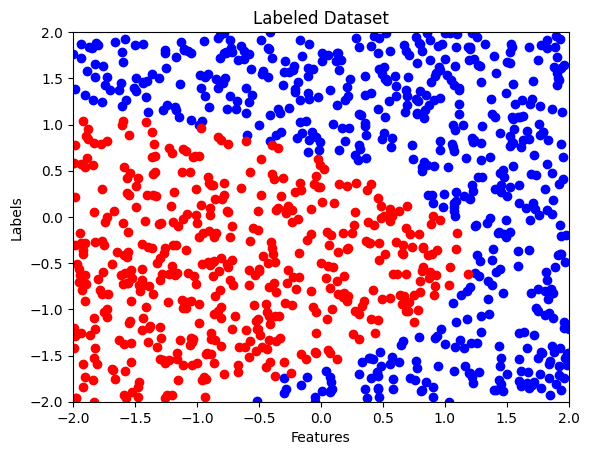

In [23]:
dataset_plot(dataset, conic_parameters, centered_data=centered_data, margin=margin, spread=spread, random=random)

### Classification

In [24]:
def logistic_regression_loss(w, b, D, p):
    
    #initialize the loss function
    loss = 0
    
    #compute the loss function for all the data-points
    for m in range(len(D)):
        z = -p[m] * (np.dot(w, phi(D[m])) + b)
        z = np.clip(z, -np.inf, 500)  # Clip values to prevent overflow
        loss += np.log(1 + np.exp(z))

    #initialize the gradients
    grad_w = np.zeros(len(w))
    grad_b = 0.0

    #compute the gradients of the loss function
    for m in range(len(D)):
        z = -p[m] * (np.dot(w, phi(D[m])) + b)
        z = np.clip(z, -np.inf, 500)  # Clip values to prevent overflow
        exp_term = np.exp(z)
        grad_w += -p[m] * exp_term / (1 + exp_term) * phi(D[m])
        grad_b += -p[m] * exp_term / (1 + exp_term)

    return loss, grad_w, grad_b

In [25]:
def centralized_gradient_method(D, p, step_size, max_iterations, min_grad_norm):

    #initialization
    q = len(phi(D[0]))
    w = np.random.rand(q)
    b = np.random.rand()
    costs = []
    grad_norms = []
    effective_iterations = 0

    for k in range(max_iterations - 1):
        
        effective_iterations += 1
        #compute the gradient of the cost function
        loss, grad_w, grad_b = logistic_regression_loss(w, b, D, p)
        grad_norm = np.sqrt(np.sum(grad_w ** 2) + grad_b ** 2)

        #update w and b using the gradient descent
        w -= step_size * grad_w
        b -= step_size * grad_b

        #store cost and gradient norm
        costs.append(loss)
        grad_norms.append(grad_norm)

        #print progress
        if k % 200 == 0: print(f"Iteration [{k}]: Cost = {loss}, Gradient Norm = {grad_norm}")

        #stop the algorithm
        if grad_norm < min_grad_norm:

            print(f"Gradient norm is below threshold ({min_grad_norm}). Stopping optimization.")
            break

    return w, b, costs, grad_norms, effective_iterations

In [26]:
print(D_train[0][1])

-1


In [27]:
points = np.array([data[0] for data in D_train]) #P
labels = np.array([data[1] for data in D_train]) #D

### Centralized Gradient Method

#### <a name="pookie3.2"></a>Parameters

In [28]:
step_size = 0.05
max_iters = int(1e6) #maximum number of iterations
min_grad_norm = 0.1 #gradient method's stopping criterion

#### <a name="pookie3.2"></a>Algorithm

In [29]:
w_opt, b_opt, costs, grad_norms,effective_iterations = centralized_gradient_method(points, labels, step_size, max_iters, min_grad_norm)

Iteration [0]: Cost = 636.6134618572332, Gradient Norm = 525.6283952374082
Iteration [200]: Cost = 4.720286511367704, Gradient Norm = 0.1482694403908825
Iteration [400]: Cost = 4.518223419970468, Gradient Norm = 0.13707106388668183
Iteration [600]: Cost = 4.3421231140479595, Gradient Norm = 0.1284932138066341
Iteration [800]: Cost = 4.186508627559318, Gradient Norm = 0.12112081897761733
Iteration [1000]: Cost = 4.047589422999663, Gradient Norm = 0.11470443073477757
Iteration [1200]: Cost = 3.922499977285323, Gradient Norm = 0.10906061628568549
Iteration [1400]: Cost = 3.8090264951370574, Gradient Norm = 0.10405113889499122
Gradient norm is below threshold (0.1). Stopping optimization.


#### <a name="pookie3.2"></a>Cost & Gradient Plots

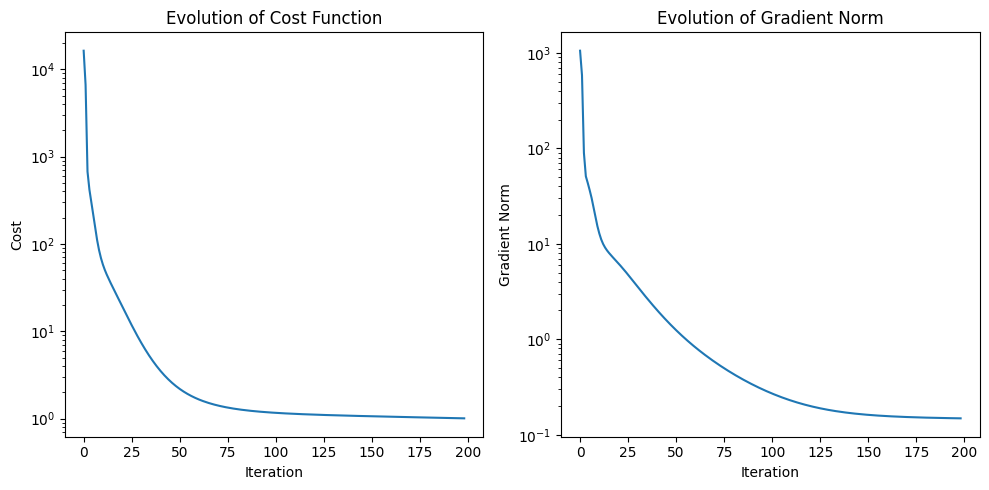

In [30]:
stop_plot = 200
#plot evolution of cost function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.semilogy(np.arange(stop_plot-1), costs[1:stop_plot] - min(costs))
#semilogy(np.arange(max_iters-1), np.abs(cost[:-1] - min(cost))
plt.title('Evolution of Cost Function')
plt.xlabel('Iteration')
plt.ylabel('Cost')

#plot evolution of gradient norm
plt.subplot(1, 2, 2)
plt.semilogy(grad_norms[1:stop_plot])
plt.title('Evolution of Gradient Norm')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.tight_layout()
plt.show()

### Classification Test

In [31]:
def plot_classification_and_true_function(points, labels, w, b, conic_parameters):
    
    # Classify each point in the grid
    Z = np.array([w.dot(phi(x)) + b for x in points])
    Z = 1 / (1 + np.exp(-Z))  # Apply sigmoid function
    Z = (Z > 0.5).astype(int)  # Threshold at 0.5

    # Define the colormap
    cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

    # Plot the points with different colors depending on their classification
    plt.scatter(points[:, 0], points[:, 1], c=Z, cmap=cmap, edgecolors='k')

    
    if conic_parameters['center'] is not None:
        
        # Plot the true ellipse
        h, k = conic_parameters['center']
        a = (conic_parameters['x_ints'][1] - conic_parameters['x_ints'][0]) / 2
        b = (conic_parameters['y_ints'][1] - conic_parameters['y_ints'][0]) / 2
        theta = np.linspace(0, 2*np.pi, 100)
        x = h + a * np.cos(theta)
        y = k + b * np.sin(theta)
        plt.plot(x, y, color="darkorange", label='Separating Function')


    else:
        #plot the true parabola

        # Generate a range of y values around the vertex
        y_vals = np.linspace(-spread, spread, 200)

        # Calculate the corresponding x values
        x_vals = [-(conic_parameters['w'][0]*y**2 + conic_parameters['w'][1]*y + conic_parameters['b']) / conic_parameters['w'][1] for y in y_vals]

        # Plot the parabola
        plt.plot(x_vals,y_vals,color="darkorange", linestyle='--', linewidth=3, label='Separating Function')
        plt.xlim(-spread, spread)
        plt.ylim(-spread, spread)

    plt.legend(framealpha=1)
    plt.show()

In [32]:
points = np.array([data[0] for data in D_train]) #P
labels = np.array([data[1] for data in D_train]) #D

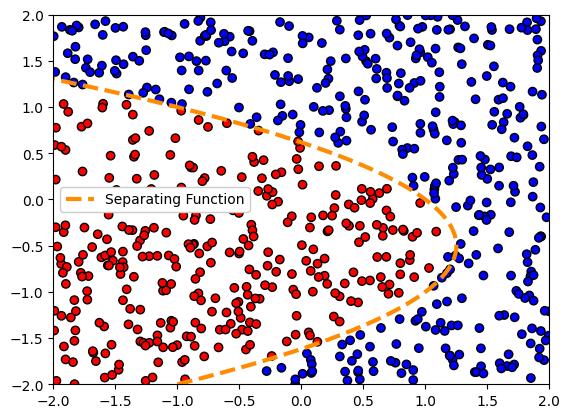

In [33]:
plot_classification_and_true_function(points, labels, w_opt, b_opt, conic_parameters) #plot of the test set

In [34]:
points = np.array([data[0] for data in D_test]) #P
labels = np.array([data[1] for data in D_test]) #D

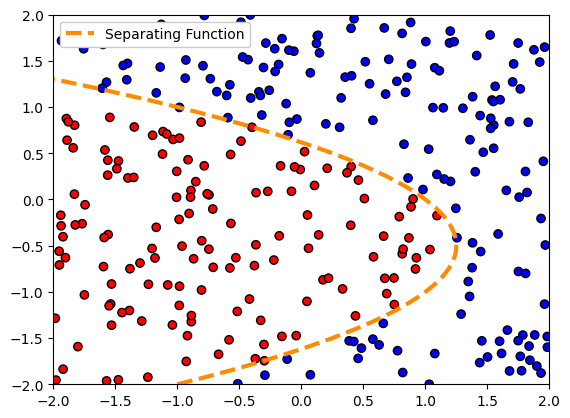

In [35]:
plot_classification_and_true_function(points, labels, w_opt, b_opt, conic_parameters) #plot of the test set

In [36]:
#show the optimal decision variables
print("\nOPTIMAL VALUES:\n")
print(f"b_opt: {b_opt}, b: {conic_parameters['b']}")
print(f"w0_opt: {w_opt[0]}, w: {conic_parameters['w'][0]}")
print(f"w1_opt: {w_opt[1]}, w: {conic_parameters['w'][1]}")
print(f"w2_opt: {w_opt[2]}, w: {conic_parameters['w'][2]}")
print(f"w3_opt: {w_opt[3]}, w: {conic_parameters['w'][3]}")


OPTIMAL VALUES:

b_opt: -27.07103669563915, b: -1
w0_opt: 25.73417054336171, w: 1
w1_opt: 25.54609541693893, w: 1
w2_opt: 2.167880073211551, w: 0
w3_opt: 25.562810476561133, w: 1


### Evaluation Metrics

In [37]:
def evaluation_metrics(y_train, y_train_pred, y_test, y_test_pred):
    
    # Compute evaluation metrics
    metrics_dict = {
        'Classification Error': [1 - accuracy_score(y_train, y_train_pred), 1 - accuracy_score(y_test, y_test_pred)],
        'Accuracy': [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)],
        'Recall': [recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)],
        'F1 Score': [f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)]
    }
    return metrics_dict

In [38]:
y_train_pred = np.array([P(data[0], w_opt, b_opt) for data in D_train])
y_test_pred = np.array([P(data[0], w_opt, b_opt) for data in D_test])

y_train = np.array([data[1] for data in D_train])
y_test = np.array([data[1] for data in D_test])

# Compute evaluation metrics
metrics_dict = evaluation_metrics(y_train, y_train_pred, y_test, y_test_pred)


In [39]:
def print_evaluation_metrics(metrics_dict):
    
    print("\n\n---------------------------------------------------------------")
    print("TRAIN-SET METRICS")
    print(f"Classification Error: {metrics_dict['Classification Error'][0]}")
    print(f"Accuracy: {metrics_dict['Accuracy'][0]}")
    print(f"Precision: {metrics_dict['Precision'][0]}")
    print(f"Recall: {metrics_dict['Recall'][0]}")
    print(f"F1 Score: {metrics_dict['F1 Score'][0]}")
    print("---------------------------------------------------------------")
    print("\n\n---------------------------------------------------------------")
    print("TEST-SET METRICS")
    print(f"Classification Error: {metrics_dict['Classification Error'][1]}")
    print(f"Accuracy: {metrics_dict['Accuracy'][1]}")
    print(f"Precision: {metrics_dict['Precision'][1]}")
    print(f"Recall: {metrics_dict['Recall'][1]}")
    print(f"F1 Score: {metrics_dict['F1 Score'][1]}")
    print("---------------------------------------------------------------")

    plt.figure(figsize=(10, 5))
    plt.bar(['Train', 'Test'], metrics_dict['Classification Error'], color=['blue', 'orange'])
    plt.title('Classification Error')
    plt.show()

    # Plot other metrics
    plt.figure(figsize=(10, 5))
    for metric, values in metrics_dict.items():
        if metric != 'Classification Error':
            plt.plot(['Train', 'Test'], values, label=metric)
    plt.title('Evaluation Metrics')
    plt.legend()
    plt.show()



---------------------------------------------------------------
TRAIN-SET METRICS
Classification Error: 0.0014285714285714457
Accuracy: 0.9985714285714286
Precision: 0.9973958333333334
Recall: 1.0
F1 Score: 0.9986962190352021
---------------------------------------------------------------


---------------------------------------------------------------
TEST-SET METRICS
Classification Error: 0.0033333333333332993
Accuracy: 0.9966666666666667
Precision: 1.0
Recall: 0.9938271604938271
F1 Score: 0.9969040247678018
---------------------------------------------------------------


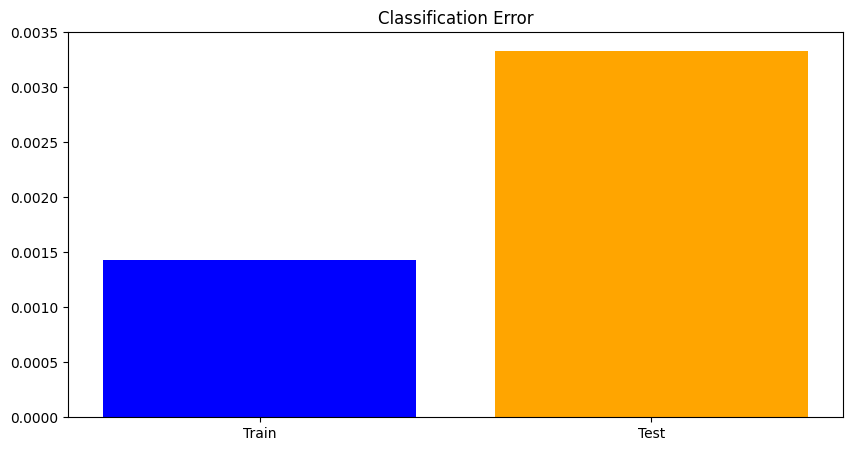

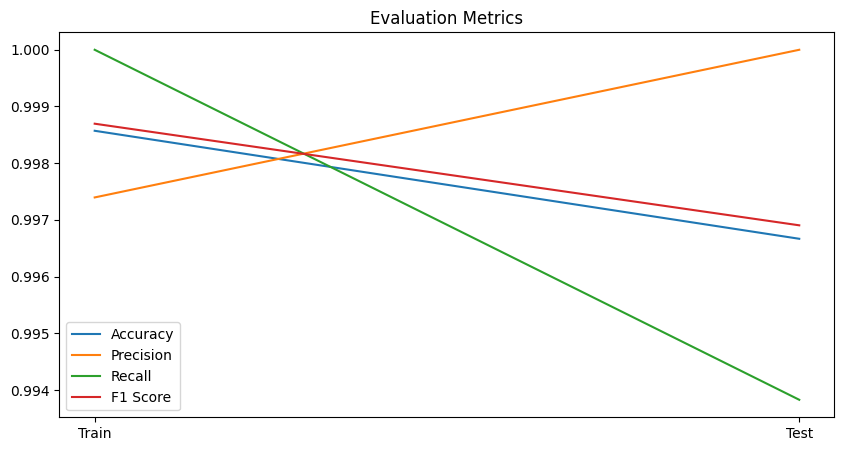

In [40]:
print_evaluation_metrics(metrics_dict)

## <a name="pookie4"></a>Task 1.3 - Distributed Classification<a name="pookie4"></a>

1. Split (randomly) the dataset in $N$ subsets, one for each agent $i \in\{1, \ldots, N\}$.
2. Implement the Gradient Tracking algorithm to classify the dataset in a distributed fashion (you can extend the code designed in Task 1.1).
3. Generate a set of simulations testing different dataset sizes and patterns, showing the convergence of the distributed algorithm to a stationary point of the optimization problem. Moreover, plot the evolution of the cost function and of the norm of the gradient of the cost function across the iterations.
4. Evaluate the quality of the obtained solution by computing the percentage of misclassified points.

### Distributed Dataset Generation

In [41]:
def distribute_data(data, num_agents, pattern):
    
    if pattern == 'sequential':
        # Sort the data by the first feature
        data.sort(key=lambda x: x[0][0])

        # Calculate the size of each slice
        slice_size = len(data) // num_agents

        # Split the data into num_agents slices
        return [data[i*slice_size:(i+1)*slice_size] for i in range(num_agents)]
    elif pattern == 'random':
        rand.shuffle(data)
        return [data[i::num_agents] for i in range(num_agents)]
    else:
        raise ValueError(f'Unknown distribution pattern: {pattern}')

In [42]:
#Add noise to D_train
def add_noise(data, noise_level):
    
    noisy_data = []
    for point, label in data:
        if rand.random() < noise_level:
            noisy_data.append((point, -label))
        else:
            noisy_data.append((point, label))
    return noisy_data

In [43]:
noise = False
split = 'sequential' #sequential or random

In [44]:
if noise:
    D_train = add_noise(D_train, 0.2)
D_train_distributed = distribute_data(D_train, N, split)

In [45]:
def plot_distributed_data(agent_datasets):
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k','orange', 'purple', 'brown' ]  # Add more colors if you have more than 10 agents

    for i, data in enumerate(agent_datasets):
        # Extract the features and labels from the data
        features = [item[0] for item in data]
        labels = [item[1] for item in data]

        # Separate the features into x and y values
        x_values = [feature[0] for feature in features]
        y_values = [feature[1] for feature in features]

        # Plot the data, coloring it based on the label
        plt.scatter(x_values, y_values, color=colors[i % len(colors)], label=f'Agent {i+1}')

    plt.legend()
    plt.show()

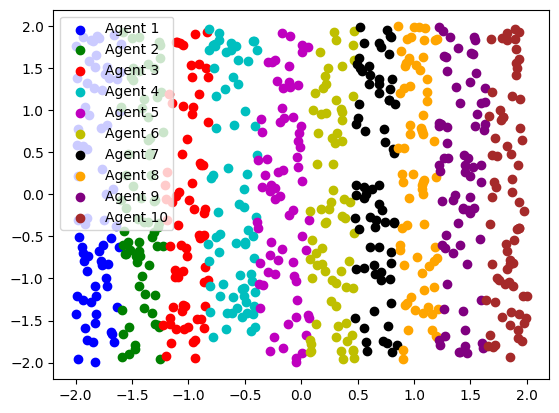

In [46]:
plot_distributed_data(D_train_distributed)

### <a name="pookie4.1"></a>Gradient Tracking Algorithm

In [47]:
def distributed_gradient_tracking(iterations, N, A, Adj, alpha, agent_datasets, eps):
    
    Z = np.zeros((iterations, N, 5))
    S = np.zeros((iterations, N, 5))
    W_norm = np.zeros((iterations,4))
    B_norm = np.zeros((iterations,1))
    cost = np.zeros((iterations))
    grad_w = np.zeros((iterations, 4)) ##
    grad_b = np.zeros((iterations, 1))
    k_max = iterations

    D = {}  # dictionary to store agents' attributes
    p = {}  # dictionary to store agents' labels

    for i in range(N):
        D[i] = np.array([data[0] for data in agent_datasets[i]])  # Attributes
        p[i] = np.array([data[1] for data in agent_datasets[i]])  # Labels
        Z[0, i, :4] = np.random.uniform(-1,1, size=4)
        Z[0, i, 4] = np.random.uniform(-1,1)
        f_z, S[0, i, :4], S[0, i, 4] = logistic_regression_loss(Z[0, i, :4], Z[0, i, 4], D[i], p[i])

        #store initial cost and gradients
        cost[0] += f_z
        grad_w[0] += S[0, i, :4]
        grad_b[0] += S[0, i, 4]

    for k in range(iterations-1):

        for i in range(N):
            
            neighbors = np.nonzero(Adj[i])[0]
            # Update the values of Z and S for each agent
            Z[k+1,i,:4] += Z[k,i,:4] * A[i,i]
            Z[k+1,i,4] += Z[k,i,4] * A[i,i]
            S[k+1,i,:4] += S[k,i,:4] * A[i,i]
            S[k+1,i,4] += S[k,i,4] * A[i,i]

            for j in neighbors:
                # Update the values of Z and S for each agent
                Z[k+1,i,:4] += Z[k,j,:4] * A[i,j]
                Z[k+1,i,4] += Z[k,j,4] * A[i,j]
                S[k+1,i,:4] += S[k,j,:4] * A[i,j]
                S[k+1,i,4] += S[k,j,4] * A[i,j]

            Z[k+1, i, :4] -= alpha * S[k, i, :4]
            Z[k+1, i, 4] -= alpha * S[k, i, 4]
            
            # update the gradients using the logistic regression loss function
            _, grad_new_w, grad_new_b = logistic_regression_loss(Z[k+1,i,:4], Z[k+1,i,4], D[i], p[i])
            _, grad_old_w, grad_old_b = logistic_regression_loss(Z[k,i,:4], Z[k,i,4], D[i], p[i])
            S[k+1,i,:4] +=  grad_new_w - grad_old_w
            S[k+1,i,4] +=  grad_new_b - grad_old_b

            #update the cost
            cost[k+1] += logistic_regression_loss(Z[k,i,:4], Z[k,i,4], D[i], p[i])[0]

            #update the gradients
            grad_w[k+1] += grad_new_w
            grad_b[k+1] += grad_new_b
        
        #compute the total gradient's norm
        grad_norm = np.sqrt(np.sum(grad_w[k+1] ** 2) + grad_b[k+1] ** 2)

        #print progress
        if k % 80 == 0: print(f"Iteration [{k}]: Gradient Norm = {grad_norm}")

        #stop the algorithm
        if grad_norm < eps:

            k_max = k
            print(f"Gradient norm is below threshold ({eps}). Stopping optimization.")
            break

    return Z, S, cost, grad_w, grad_b, k_max

### <a name="pookie4.1"></a>Parameters

In [48]:
Adj = generate_graph(N,seed)
A = metropolis_hastings(N, Adj)
alpha = 0.05
iterations = 2000
eps = 0.5

### <a name="pookie4.1"></a>Simulations

In [49]:
Z, S, cost, grad_w, grad_b, stop_plot = distributed_gradient_tracking(iterations, N, A, Adj, alpha, D_train_distributed, eps)

Iteration [0]: Gradient Norm = [269.15369999]
Iteration [80]: Gradient Norm = [13.77230384]
Iteration [160]: Gradient Norm = [3.97360407]
Iteration [240]: Gradient Norm = [1.91004932]
Iteration [320]: Gradient Norm = [1.1044171]
Iteration [400]: Gradient Norm = [0.79275585]
Iteration [480]: Gradient Norm = [0.67832402]
Iteration [560]: Gradient Norm = [0.63310888]
Iteration [640]: Gradient Norm = [0.60970421]
Iteration [720]: Gradient Norm = [0.59322996]
Iteration [800]: Gradient Norm = [0.57928981]
Iteration [880]: Gradient Norm = [0.56656814]
Iteration [960]: Gradient Norm = [0.55464165]
Iteration [1040]: Gradient Norm = [0.54335067]
Iteration [1120]: Gradient Norm = [0.53261705]
Iteration [1200]: Gradient Norm = [0.52239029]
Iteration [1280]: Gradient Norm = [0.51263096]
Iteration [1360]: Gradient Norm = [0.50330535]
Gradient norm is below threshold (0.5). Stopping optimization.


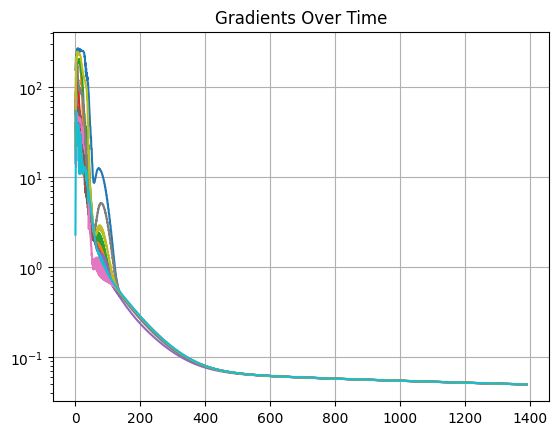

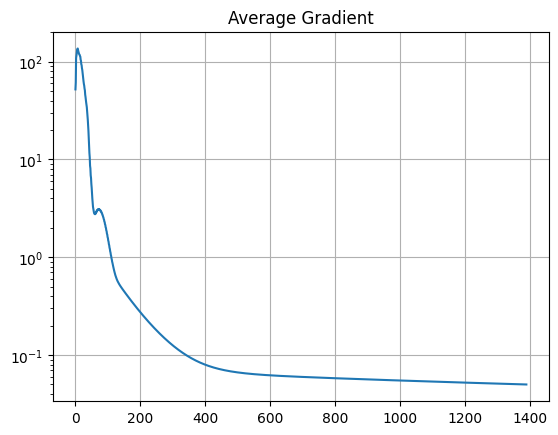

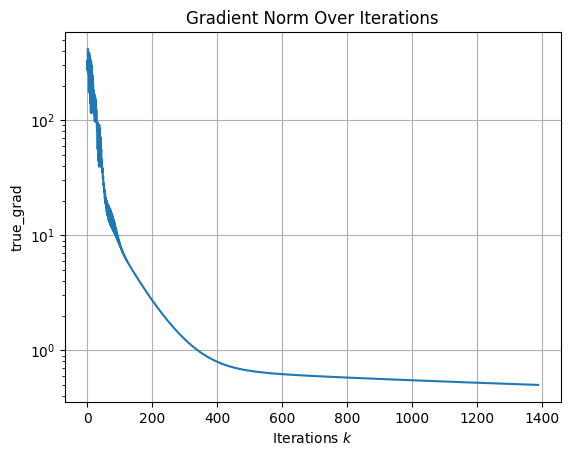

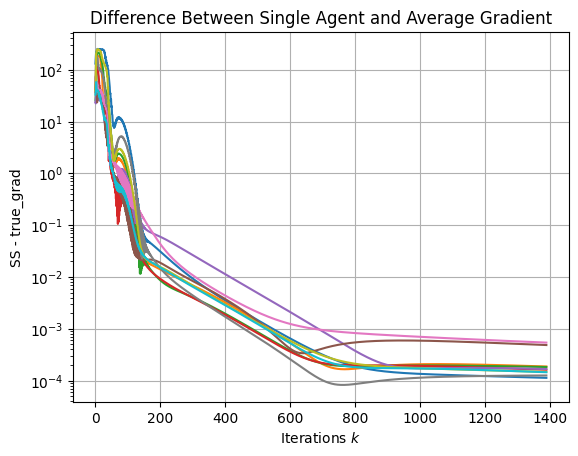

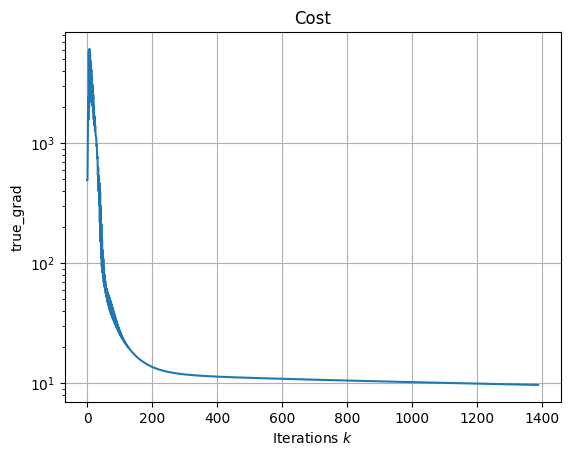

In [50]:
#convert S to it's norm
S_norm = np.linalg.norm(S[:stop_plot], axis=2)
#plot S
fig, ax = plt.subplots()
for i in range(N):
    ax.semilogy(np.arange(stop_plot), S_norm[:,i])
ax.title.set_text('Gradients Over Time')
ax.grid()

#plot the average gradient
fig, ax = plt.subplots()
average_gradient = np.mean(S_norm, axis=1)
ax.semilogy(np.arange(stop_plot), average_gradient)
ax.title.set_text('Average Gradient')
ax.grid()

#compute the gradient norm
grad_norm_w = np.linalg.norm(grad_w, axis=1)  
grad_norm_b = np.linalg.norm(grad_b, axis=1)
total_gradient_norm = np.sqrt(grad_norm_w**2 + grad_norm_b**2)

#plot the gradient norm
fig, ax = plt.subplots()
ax.semilogy(np.arange(stop_plot), total_gradient_norm[:stop_plot])
ax.set_xlabel(r"Iterations $k$")
ax.set_ylabel(r"true_grad")
ax.title.set_text('Gradient Norm Over Iterations')
ax.grid()

#compute the true gradient
true_grad = np.hstack((grad_w, grad_b)) #shape (iterations, 5)

#plot difference between single agent and average gradient
fig, ax = plt.subplots()
for ii in range(N): ax.plot(np.arange(stop_plot), np.linalg.norm(S[:stop_plot, ii, :] - true_grad[:stop_plot]/N, axis=1))
ax.set_yscale('log')
ax.set_xlabel(r"Iterations $k$")
ax.set_ylabel(r"SS - true_grad")
ax.set_title("Difference Between Single Agent and Average Gradient")
ax.grid()

#plot the cost
fig, ax = plt.subplots()
ax.title.set_text('Cost')
ax.set_xlabel(r"Iterations $k$")
ax.set_ylabel(r"true_grad")
ax.semilogy(np.arange(stop_plot-1), (cost[:stop_plot-1]))
ax.grid()


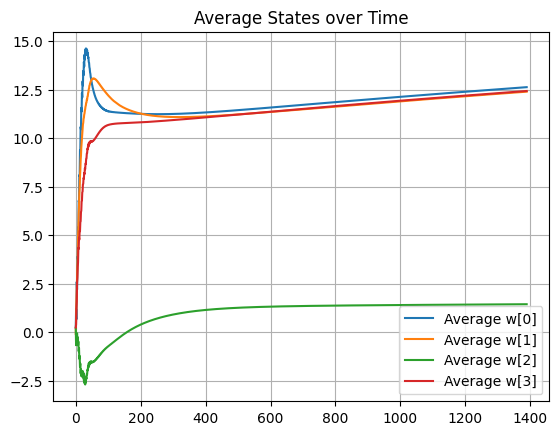

In [51]:
#plot average Z
plt.figure()
for k in range(4):
    avg_Z = np.mean(Z[:,:,k], axis=1)  # calculate average over agents
    plt.plot(np.arange(stop_plot), avg_Z[:stop_plot], label=f'Average w[{k}]')
plt.title('Average States over Time')
plt.grid()
plt.legend()
plt.show()

### <a name="pookie4.1"></a>Classification Test

In [52]:
w_opt_distributed = np.mean(Z[-1,:,:4], axis=0)
b_opt_distributed = np.mean(Z[-1,:,4], axis=0)

In [53]:
points = np.array([data[0] for data in D_train]) #P
labels = np.array([data[1] for data in D_train]) #D

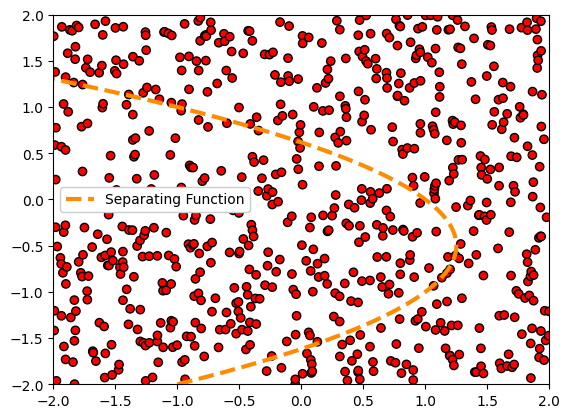

In [54]:
plot_classification_and_true_function(points, labels, w_opt_distributed, b_opt_distributed, conic_parameters)

In [55]:
points = np.array([data[0] for data in D_test]) #P
labels = np.array([data[1] for data in D_test]) #D

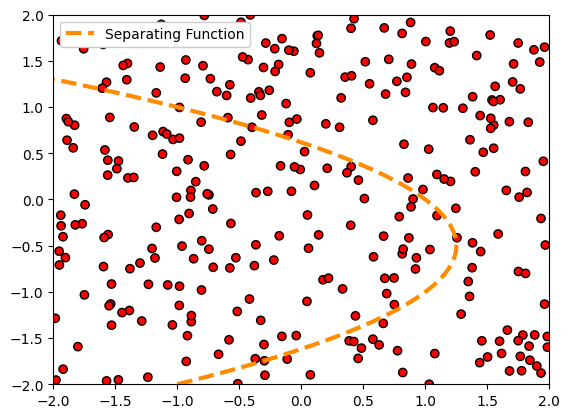

In [56]:
plot_classification_and_true_function(points, labels, w_opt_distributed, b_opt_distributed, conic_parameters)

### <a name="pookie4.1"></a>Classification Test with Noise

In [57]:
points = np.array([data[0] for data in D_test]) #P
labels = np.array([data[1] for data in D_test]) #D

noise = np.random.normal(scale=0.2, size=points.shape)
points_noisy = points + noise

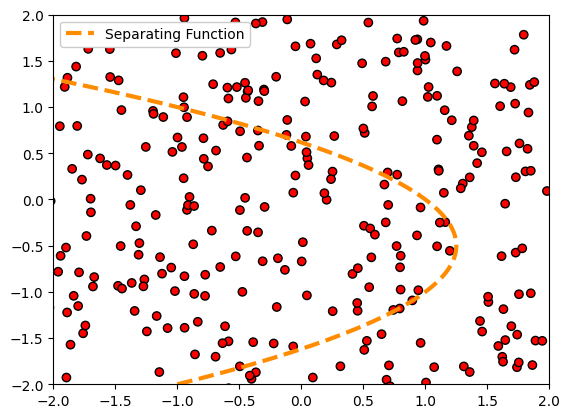

In [58]:
plot_classification_and_true_function(points_noisy, labels, w_opt_distributed, b_opt_distributed, conic_parameters)

### <a name="pookie4.1"></a>Evaluation Metrics

In [59]:
y_train_pred = np.array([P(data[0], w_opt_distributed, b_opt_distributed) for data in D_train])
y_test_pred = np.array([P(data[0], w_opt_distributed, b_opt_distributed) for data in D_test])

y_train = np.array([data[1] for data in D_train])
y_test = np.array([data[1] for data in D_test])

# Compute evaluation metrics
metrics_dict = evaluation_metrics(y_train, y_train_pred, y_test, y_test_pred)



---------------------------------------------------------------
TRAIN-SET METRICS
Classification Error: 0.45285714285714285
Accuracy: 0.5471428571428572
Precision: 0.5471428571428572
Recall: 1.0
F1 Score: 0.7072945521698984
---------------------------------------------------------------


---------------------------------------------------------------
TEST-SET METRICS
Classification Error: 0.45999999999999996
Accuracy: 0.54
Precision: 0.54
Recall: 1.0
F1 Score: 0.7012987012987013
---------------------------------------------------------------


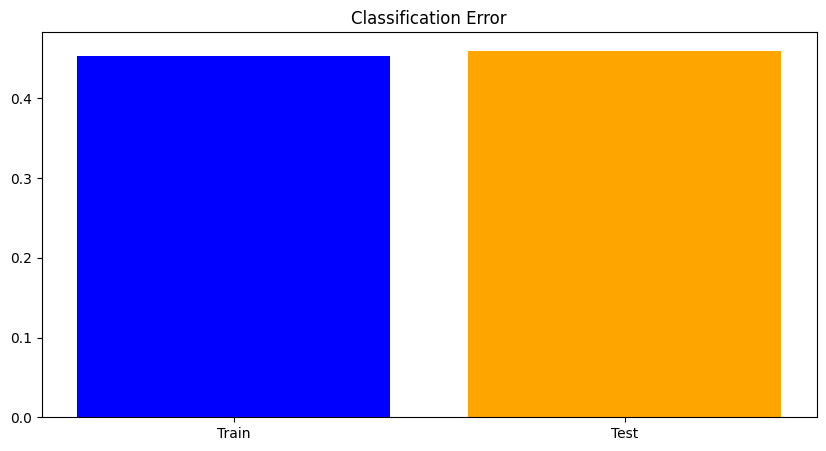

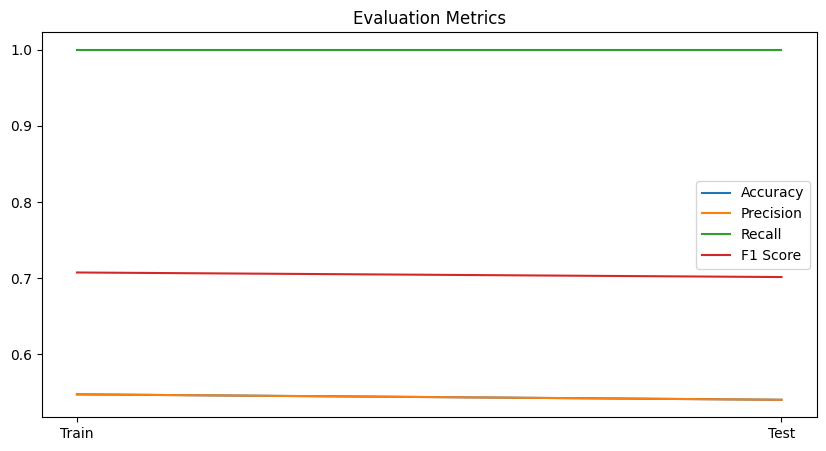

In [60]:
print_evaluation_metrics(metrics_dict)

### <a name="pookie4.1"></a>Evaluation with Noise

In [61]:
points_test = np.array([data[0] for data in D_test])
labels_test = np.array([data[1] for data in D_test])

# Add noise
noise_test = np.random.normal(scale=0.2, size=points_test.shape)
points_test_noisy = points_test + noise_test

# Make predictions
y_train_pred = np.array([P(data[0], w_opt_distributed, b_opt_distributed) for data in D_train])
y_test_pred = np.array([P(point, w_opt_distributed, b_opt_distributed) for point in points_test_noisy])

# Compute evaluation metrics
metrics_dict = evaluation_metrics(y_train, y_train_pred, labels_test, y_test_pred)



---------------------------------------------------------------
TRAIN-SET METRICS
Classification Error: 0.45285714285714285
Accuracy: 0.5471428571428572
Precision: 0.5471428571428572
Recall: 1.0
F1 Score: 0.7072945521698984
---------------------------------------------------------------


---------------------------------------------------------------
TEST-SET METRICS
Classification Error: 0.45999999999999996
Accuracy: 0.54
Precision: 0.54
Recall: 1.0
F1 Score: 0.7012987012987013
---------------------------------------------------------------


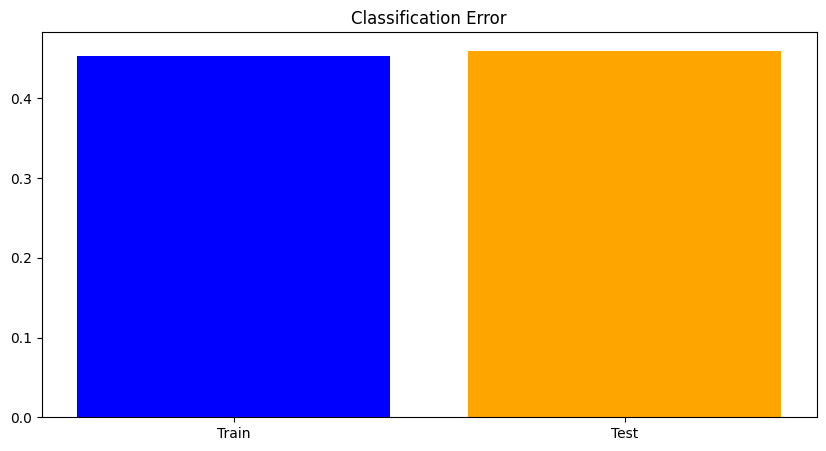

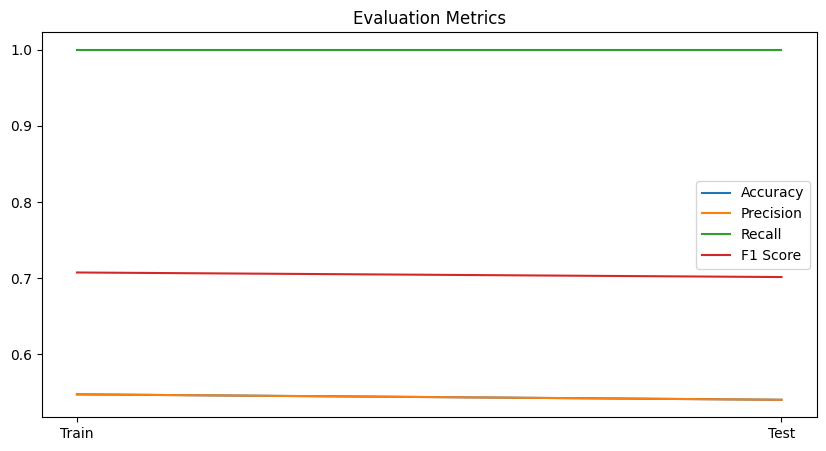

In [62]:
print_evaluation_metrics(metrics_dict)